In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding

In [ ]:
data = pd.read_csv('mar.txt', delimiter='\t', names=['English', 'Marathi', 'Attribution'])


In [ ]:
data.head()

,English,Marathi,Attribution
0,Go.,जा.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Run!,पळ!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
2,Run!,धाव!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,Run!,पळा!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run!,धावा!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [ ]:
data = data[['English', 'Marathi']]
data['English'] = data['English'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
data['Marathi'] = data['Marathi'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
data['Marathi'] = data['Marathi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
data['Marathi'] = data['Marathi'].apply(lambda x: re.sub("[\u200d]", "", x))
data['Marathi'] = data['Marathi'].apply(lambda x: 'start ' + x + ' end')

<ipython-input-5-eb92dbb78b2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['English'] = data['English'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
<ipython-input-5-eb92dbb78b2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Marathi'] = data['Marathi'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
<ipython-input-5-eb92dbb78b2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['English'], data['Marathi'], test_size=0.1)


In [ ]:

tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(X_train)
vocab_size_eng = len(tokenizer_eng.word_index) + 1

tokenizer_mar = Tokenizer()
tokenizer_mar.fit_on_texts(y_train)
vocab_size_mar = len(tokenizer_mar.word_index) + 1

X_train_seq = tokenizer_eng.texts_to_sequences(X_train)
X_test_seq = tokenizer_eng.texts_to_sequences(X_test)
y_train_seq = tokenizer_mar.texts_to_sequences(y_train)
y_test_seq = tokenizer_mar.texts_to_sequences(y_test)

In [ ]:
max_len_eng = 37
max_len_mar = 37

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len_eng, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len_eng, padding='post')
y_train_padded = pad_sequences(y_train_seq, maxlen=max_len_mar, padding='post')
y_test_padded = pad_sequences(y_test_seq, maxlen=max_len_mar, padding='post')

In [ ]:

latent_dim = 128


encoder_inputs = Input(shape=(max_len_eng,))
enc_emb = Embedding(vocab_size_eng, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [ ]:
decoder_inputs = Input(shape=(max_len_mar-1,))
dec_emb_layer = Embedding(vocab_size_mar, latent_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_mar, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 64
epochs = 30

In [ ]:
history = model.fit([X_train_padded, y_train_padded[:, :-1]], y_train_padded[:, 1:], batch_size=batch_size, epochs=epochs, validation_data=([X_test_padded, y_test_padded[:, :-1]], y_test_padded[:, 1:]))


Epoch 1/30
661/661 [==============================] - 49s 59ms/step - loss: 5.4556 - accuracy: 0.2663 - val_loss: 4.7641 - val_accuracy: 0.3310
Epoch 2/30
661/661 [==============================] - 30s 46ms/step - loss: 4.7536 - accuracy: 0.3361 - val_loss: 4.5444 - val_accuracy: 0.3506
Epoch 3/30
661/661 [==============================] - 31s 47ms/step - loss: 4.5459 - accuracy: 0.3555 - val_loss: 4.3819 - val_accuracy: 0.3640
Epoch 4/30
661/661 [==============================] - 30s 46ms/step - loss: 4.3783 - accuracy: 0.3776 - val_loss: 4.2328 - val_accuracy: 0.3876
Epoch 5/30
661/661 [==============================] - 30s 45ms/step - loss: 4.2317 - accuracy: 0.3917 - val_loss: 4.1075 - val_accuracy: 0.3979
Epoch 6/30
661/661 [==============================] - 30s 45ms/step - loss: 4.0913 - accuracy: 0.4066 - val_loss: 3.9886 - val_accuracy: 0.4144
Epoch 7/30
661/661 [==============================] - 29s 44ms/step - loss: 3.9540 - accuracy: 0.4243 - val_loss: 3.8617 - val_accuracy:

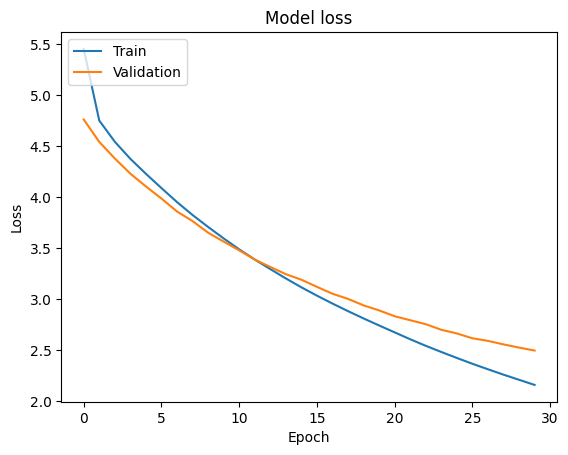

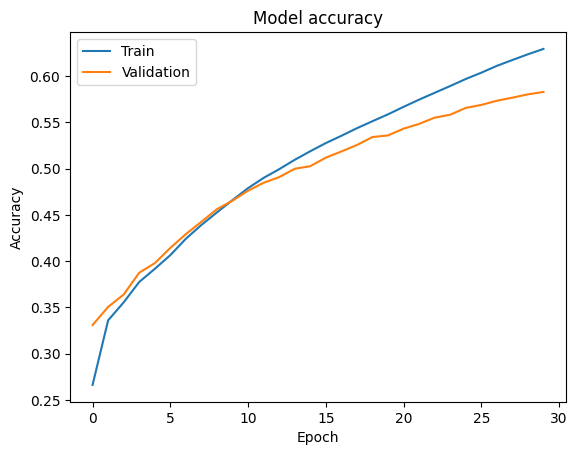

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate([X_test_padded, y_test_padded[:, :-1]], y_test_padded[:, 1:])
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

147/147 [==============================] - 3s 23ms/step - loss: 2.4984 - accuracy: 0.5830
Test Loss: 2.4983530044555664
Test Accuracy: 0.583014965057373


In [ ]:
print(f"X_test shape: {X_test.shape}")
print(f"X_test_padded shape: {X_test_padded.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (4699,)
X_test_padded shape: (4699, 37)
y_test shape: (4699,)


In [ ]:
reverse_target_word_index = {v: k for k, v in tokenizer_mar.word_index.items()}


In [ ]:

encoder_model = Model(encoder_inputs, encoder_states)


decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)


In [ ]:

tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(X_train)
vocab_size_eng = len(tokenizer_eng.word_index) + 1

tokenizer_mar = Tokenizer()
tokenizer_mar.fit_on_texts(y_train)
vocab_size_mar = len(tokenizer_mar.word_index) + 1

reverse_target_word_index = {v: k for k, v in tokenizer_mar.word_index.items()}


def decode_sequence(input_seq):

    states_value = encoder_model.predict(input_seq)


    target_seq = np.zeros((1, 1))


    target_seq[0, 0] = tokenizer_mar.word_index['start']


    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)


        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_word_index.get(sampled_token_index, '<UNK>')
        decoded_sentence += sampled_char + ' '


        if (sampled_char == 'end' or len(decoded_sentence.split()) > max_len_mar):
            stop_condition = True


        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index


        states_value = [h, c]

    return decoded_sentence





In [ ]:
0for seq_index in range(5):
    input_seq = X_test_padded[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', X_test.iloc[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 19ms/step
-
Input sentence: i met tom a few months ago
Decoded sentence: टॉम मला काही काही बर्यापैकी पाहिलं end 
1/1 [==============================] - 0s 19ms/step
-
Input sentence: i dont like it either
Decoded sentence: मला आवडत नाही end 
1/1 [==============================] - 0s 20ms/step
-
Input sentence: hes old and crazy
Decoded sentence: तो तरुण आहेत end 
1/1 [==============================] - 0s 19ms/step
-
Input sentence: you dont understand these things
Decoded sentence: तू तुम्हाला सगळं माहीत नाही end 
1/1 [==============================] - 0s 21ms/step
-
Input sentence: well begin work soon
Decoded sentence: आपण लवकरच सुरू होत नाही end 


In [ ]:

input_seq = "hi"
decoded_sentence = decode_sequence(input_seq)
print('Input sentence:', X_test.iloc[seq_index])
print('Decoded sentence:', decoded_sentence)